# Spike Cascades and Brain Criticality - Analysis of 3 Patients

In [2]:
import os
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

SPIKES_DIRECTORY = "../Data/spikes"
ERIN_DIRECTORY = "../../../erinconr/projects/fc_toolbox/results/analysis/intermediate/"

In [3]:
temp = []
# Iterate through all .mat files in ERIN_DIRECTORY
for filename in os.listdir(ERIN_DIRECTORY):
    mat_file = scipy.io.loadmat(
        os.path.join(ERIN_DIRECTORY, filename),
    )
    mat_file = mat_file["summ"][0]
    for index, key in enumerate(mat_file.dtype.names):
        # print(index, key, mat_file[0][index].shape)
        if key == "spikes":
            temp.append(index)
spikes_index = np.unique(np.array(temp, dtype=int))
assert spikes_index.shape[0] == 1
spikes_index = spikes_index[0]

## HUP 165

In [4]:
patient_hup_ids = [165]
LCF_THRESHOLD = 50
LCF_SHADE_END = None

In [5]:
for patient_hup_id in patient_hup_ids:
    mat_file = scipy.io.loadmat(
        os.path.join(ERIN_DIRECTORY, f"HUP{str(patient_hup_id)}.mat")
    )
    mat_file = mat_file["summ"][0][0]
    patient_spikes = mat_file[spikes_index]
    print(patient_spikes.shape)

(192, 2757)


In [6]:
def calculate_spike_cascade_distribution(patient_spikes_segment):
    patient_spikes_segment = patient_spikes_segment.copy()
    patient_spikes_segment[np.isnan(patient_spikes_segment)] = 0

    # # make every element that's greater than 0 equal to 1
    # patient_spikes_segment[patient_spikes_segment > 0] = 1

    # Compute the size of spike cascade for each window
    cascade_sizes = np.sum(patient_spikes_segment, axis=0)

    # Compute the frequency of each size
    unique_sizes, counts = np.unique(cascade_sizes, return_counts=True)

    # Compute the probabilities
    probabilities = counts / len(cascade_sizes)

    return unique_sizes, probabilities

### Overall distribution

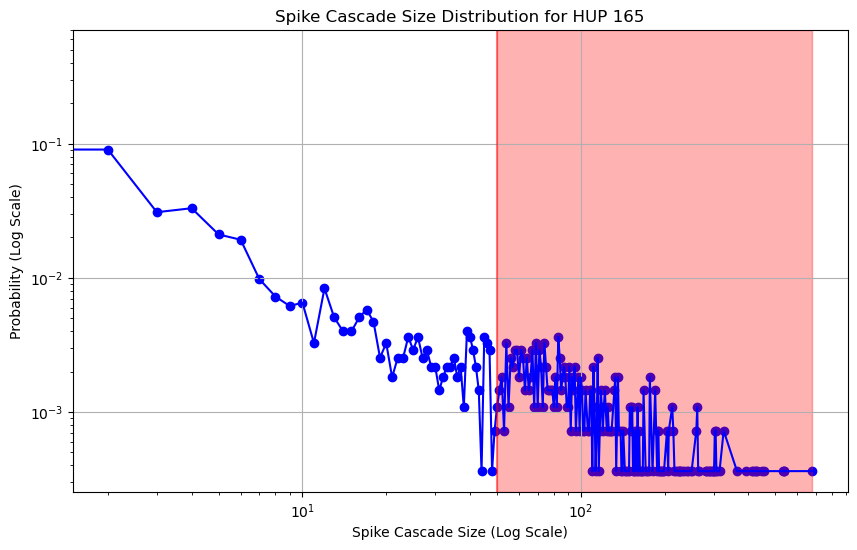

In [7]:
# Plot the distribution
unique_sizes, probabilities = calculate_spike_cascade_distribution(patient_spikes)
plt.figure(figsize=(10, 6))
plt.scatter(unique_sizes, probabilities, c="b")
plt.xscale("log")
plt.yscale("log")
plt.loglog(unique_sizes, probabilities, "b-")
plt.axvline(x=LCF_THRESHOLD, color="r", linestyle="-", alpha=0.5)
if LCF_SHADE_END is None:
    LCF_SHADE_END = max(unique_sizes)
plt.axvspan(LCF_THRESHOLD, LCF_SHADE_END, color="r", alpha=0.3)

plt.title(f"Spike Cascade Size Distribution for HUP {patient_hup_id}")
plt.xlabel("Spike Cascade Size (Log Scale)")
plt.ylabel("Probability (Log Scale)")
plt.grid(True)
plt.show()

### Day by day

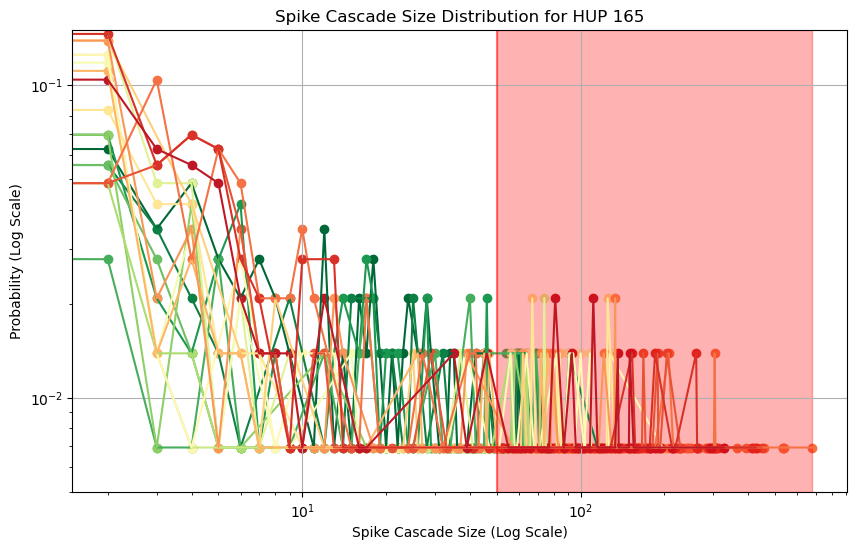

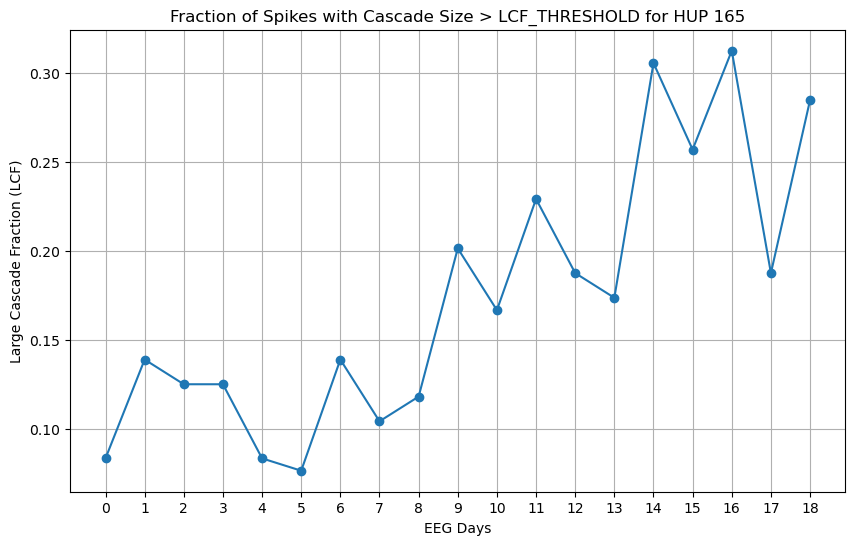

In [12]:
max_eeg_days = round(patient_spikes.shape[1] / 6 / 24)
plt.figure(figsize=(10, 6))

# Create empty list to hold fractions
fractions = []

# create a color map
cmap = plt.cm.RdYlGn

for eeg_day in range(max_eeg_days):
    start_col_index = eeg_day * 6 * 24
    end_col_index = start_col_index + 6 * 24
    eeg_hour_spikes = patient_spikes[:, start_col_index:end_col_index]
    unique_sizes, probabilities = calculate_spike_cascade_distribution(eeg_hour_spikes)

    # Calculate fraction of spikes with cascade size more than LCF_THRESHOLD
    mask = unique_sizes > LCF_THRESHOLD
    fraction = sum(probabilities[mask])
    fractions.append(fraction)

    # normalize the day with max_days to get a color
    day_norm = eeg_day / max_eeg_days
    day_color = cmap(
        1.0 - day_norm
    )  # use 1.0 - day_norm to make it transition from green to red

    plt.scatter(unique_sizes, probabilities, color=day_color)  # use the color argument
    plt.xscale("log")
    plt.yscale("log")
    plt.loglog(unique_sizes, probabilities, "-", color=day_color)


plt.axvline(x=LCF_THRESHOLD, color="r", linestyle="-", alpha=0.5)
plt.axvspan(LCF_THRESHOLD, LCF_SHADE_END, color="r", alpha=0.3)

plt.title(f"Spike Cascade Size Distribution for HUP {patient_hup_id}")
plt.ylim(0.005, 0.15)
plt.xlabel("Spike Cascade Size (Log Scale)")
plt.ylabel("Probability (Log Scale)")
plt.grid(True)
plt.show()

# After the loop
plt.figure(figsize=(10, 6))
plt.plot(range(max_eeg_days), fractions, "o-")
plt.xlabel("EEG Days")
plt.ylabel("Large Cascade Fraction (LCF)")
plt.title(
    f"Fraction of Spikes with Cascade Size > LCF_THRESHOLD for HUP {patient_hup_id}"
)

# Set the x-ticks to be integers
plt.xticks(range(max_eeg_days))

plt.grid(True)
plt.show()

### Before/after taper

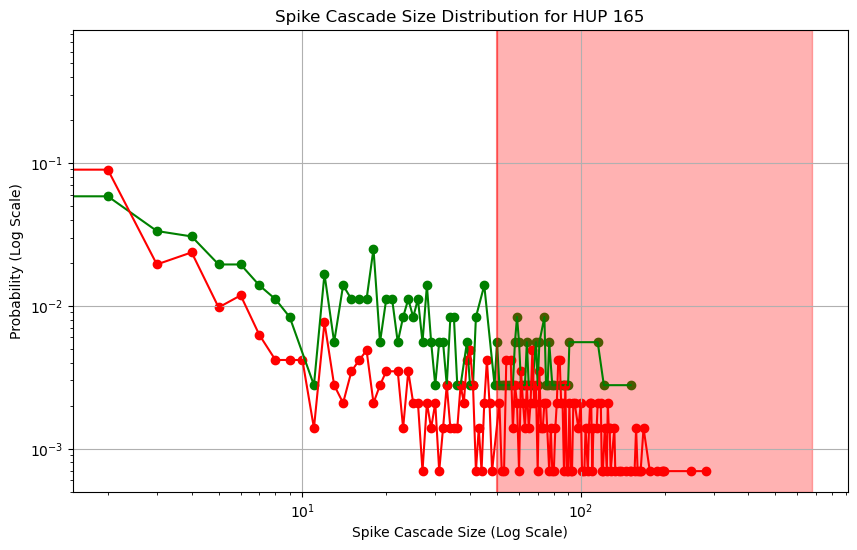

In [9]:
before_taper_period = (0, 60 * 6)
after_taper_period = (60 * 6 + 1, 1800)

plt.figure(figsize=(10, 6))

# Plot the distribution
unique_sizes_before, probabilities_before = calculate_spike_cascade_distribution(
    patient_spikes[:, before_taper_period[0] : before_taper_period[1]]
)

plt.scatter(unique_sizes_before, probabilities_before, c="g")
plt.xscale("log")
plt.yscale("log")
plt.loglog(unique_sizes_before, probabilities_before, "g-")

# Plot the distribution
unique_sizes_after, probabilities_after = calculate_spike_cascade_distribution(
    patient_spikes[:, after_taper_period[0] : after_taper_period[1]]
)

plt.scatter(unique_sizes_after, probabilities_after, c="r")
plt.xscale("log")
plt.yscale("log")
plt.loglog(unique_sizes_after, probabilities_after, "r-")


plt.axvline(x=LCF_THRESHOLD, color="r", linestyle="-", alpha=0.5)
plt.axvspan(LCF_THRESHOLD, LCF_SHADE_END, color="r", alpha=0.3)

plt.title(f"Spike Cascade Size Distribution for HUP {patient_hup_id}")
plt.xlabel("Spike Cascade Size (Log Scale)")
plt.ylabel("Probability (Log Scale)")
plt.grid(True)
plt.show()